# This is for wwall subroutine example

In [1]:
using Revise
using Pkg
Pkg.activate("..")
# Pkg.resolve()
using JPEC, Plots

  Activating project at `~/Desktop/code/GPEC_hackaton/JPEC`


In [2]:
vac_math_path = joinpath(@__DIR__, "..","src", "Vacuum", "Vacuum_math.jl");
include(vac_math_path)
vac_data_path = joinpath(@__DIR__, "..","src", "Vacuum", "Vacuum_data.jl");
include(vac_data_path)
vac_data_path = joinpath(@__DIR__, "..","src", "Vacuum", "Vacuum_wall.jl");
include(vac_data_path)

wwall

# Test D3D wall

Calling d3dwall! with mthh_val = 512 and rext_val = 1.0...
d3dwall! call completed. Check output below:

--- Verification ---
Is xwall_output empty? No
Is ywall_output empty? No
Length of xwall_output: 513 (Expected: 513)
Length of ywall_output: 513 (Expected: 513)
xwall_output[1] (2.446648) vs xwall_output[end] (2.446648): Match? Yes
ywall_output[1] (0.000000) vs ywall_output[end] (0.000000): Match? Yes

--- Sample Points (R, Z) ---
Point   1: R =   2.4466, Z =   0.0000
Point   2: R =   2.4465, Z =  -0.0105
Point   3: R =   2.4462, Z =  -0.0210
Point   4: R =   2.4456, Z =  -0.0313
Point   5: R =   2.4449, Z =  -0.0415
...
Point 508: R =   2.4441, Z =   0.0516
Point 509: R =   2.4449, Z =   0.0415
Point 510: R =   2.4456, Z =   0.0313
Point 511: R =   2.4462, Z =   0.0210
Point 512: R =   2.4465, Z =   0.0105
Point 513: R =   2.4466, Z =   0.0000


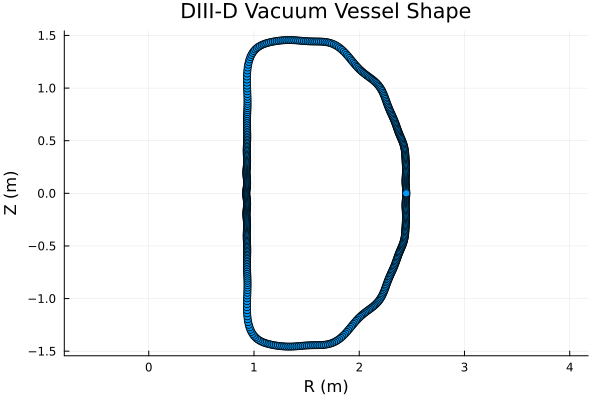

In [3]:

# 1. Define input parameters
# mthh is the number of points for the wall, also equivalent to npts for d3dvesl!
mthh_val = 512 # A reasonable number of points for a smooth curve
rext_val = 1.0 # External scaling factor, usually 1.0 for standard DIII-D wall
zlim_val = 0.0 # This value is overwritten to 0.0 inside d3dwall! for zstart

# 2. Initialize output vectors
# xwall and ywall need to be mthh_val + 1 long because d3dwall! adds the first point at the end
xwall_output = Vector{Float64}(undef, mthh_val + 1)
ywall_output = Vector{Float64}(undef, mthh_val + 1)

# 3. Set up IO streams
# `devnull` suppresses output. Use `stdout` to see messages in the console.
iomod_stream = devnull # You can change this to stdout if you want to see "ier in d3dwall" for iomod
iotty1_stream = stdout # Prints "ier in d3dwall" to your terminal

# 4. Call the d3dwall! function
println("Calling d3dwall! with mthh_val = $mthh_val and rext_val = $rext_val...")
d3dwall!(xwall_output, ywall_output, mthh_val, rext_val)
println("d3dwall! call completed. Check output below:")

# 5. Verify the results
println("\n--- Verification ---")

# Check if the output vectors are populated
@printf "Is xwall_output empty? %s\n" isempty(xwall_output) ? "Yes" : "No"
@printf "Is ywall_output empty? %s\n" isempty(ywall_output) ? "Yes" : "No"

# Check the lengths
@printf "Length of xwall_output: %d (Expected: %d)\n" length(xwall_output) (mthh_val + 1)
@printf "Length of ywall_output: %d (Expected: %d)\n" length(ywall_output) (mthh_val + 1)

# Check if the first and last points match (as d3dwall! explicitly sets them)
# Use ≈ for approximate equality with floating-point numbers
@printf "xwall_output[1] (%f) vs xwall_output[end] (%f): Match? %s\n" xwall_output[1] xwall_output[end] (xwall_output[1] ≈ xwall_output[end]) ? "Yes" : "No"
@printf "ywall_output[1] (%f) vs ywall_output[end] (%f): Match? %s\n" ywall_output[1] ywall_output[end] (ywall_output[1] ≈ ywall_output[end]) ? "Yes" : "No"

# Print a few sample points to visually inspect the shape (optional, for debugging)
println("\n--- Sample Points (R, Z) ---")
for i in 1:min(5, mthh_val)
    @printf "Point %3d: R = %8.4f, Z = %8.4f\n" i xwall_output[i] ywall_output[i]
end
println("...")
for i in max(1, mthh_val-4):mthh_val+1
    @printf "Point %3d: R = %8.4f, Z = %8.4f\n" i xwall_output[i] ywall_output[i]
end

using Plots
plot(xwall_output, ywall_output, seriestype=:scatter, legend=false, aspect_ratio=:equal,
     xlabel="R (m)", ylabel="Z (m)", title="DIII-D Vacuum Vessel Shape")
# savefig("d3d_vessel_shape.png") # Saves the plot to a file
# println("\nPlot saved to d3d_vessel_shape.png")

# How to use in JPEC

Globals initialized with dummy plasma data.
Calculating walls for ishapes: [6, 8, 5]...
All wall calculations complete.
Generating plot...


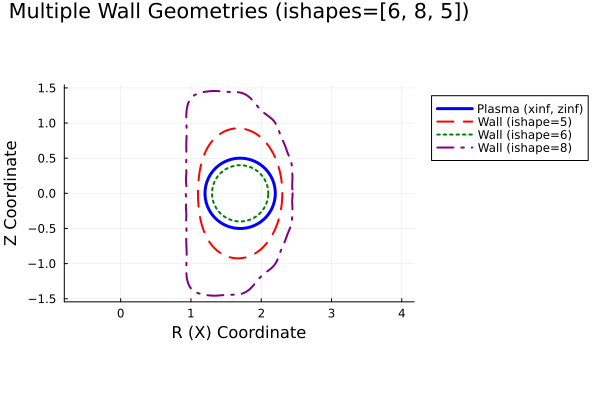

In [4]:
using Plots

# (Assuming all required structs and functions like wwall, d3dwall!, etc., are defined)

# --- 1. Initialize Settings and Globals ---
vac_set = VacuumSettingsType()
vac_glob = VacuumGlobalsType()

# Set essential flags to enable wall calculation
vac_glob.farwal = false # Must be false to calculate a wall
vac_set.shape.a = 1.0   # Set a < 10 to avoid 'far wall' logic

# 1.3. Create common dummy plasma boundary (circular)
mth2 = vac_glob.mth2 
theta = range(0, 2π, length=mth2)
R_center = 1.7
a_minor = 0.5
Z_center = 0.0
vac_glob.xinf = [R_center + a_minor * cos(t) for t in theta]
vac_glob.zinf = [Z_center + a_minor * sin(t) for t in theta]

println("Globals initialized with dummy plasma data.")

# --- 2. Calculate Walls for Multiple 'ishape' values ---
wall_results = Dict{Int, Tuple{Vector{Float64}, Vector{Float64}}}()
ishapes_to_plot = [6, 8, 5]

println("Calculating walls for ishapes: $(ishapes_to_plot)...")

for ishape_val in ishapes_to_plot
    
    # Modify vac_set fields for the current case
    vac_set.vacdat.ishape = ishape_val
    vac_set.modes.leqarcw = 0 # Disable eqarcw cleanup
    
    if ishape_val == 6
        # ishape=6: Conforming wall. 'aw' is the distance.
        vac_set.shape.a = 0.2 
        
    elseif ishape_val == 8
        # ishape=8: DIII-D. No extra params needed.
        
    elseif ishape_val == 5
        # ishape=5: Scaled D-shape.
        vac_set.vacdat.aw = 0.2    # gap
        vac_set.vacdat.bw = 1.5   # elongation
        vac_set.vacdat.dw = 0.3   # triangularity
    end

    # Run calculation
    x_wall, z_wall = wwall(vac_set, vac_glob)
    
    # Store results
    wall_results[ishape_val] = (x_wall, z_wall)
end

println("All wall calculations complete.")

# --- 3. Plot All Results ---
println("Generating plot...")

# Use mth1 (mth+1) to avoid plotting the last (0,0) point
mth1 = vac_glob.mth1

# 3.1. Plot the plasma boundary first
p = plot(
    vac_glob.xinf[1:mth1], 
    vac_glob.zinf[1:mth1],
    label = "Plasma (xinf, zinf)",
    linewidth = 3, # Make plasma line thicker
    color = :blue,
    xlabel = "R (X) Coordinate",
    ylabel = "Z Coordinate",
    title = "Multiple Wall Geometries (ishapes=$(ishapes_to_plot))",
    aspect_ratio = :equal,
    legend = :outertopright
)

# 3.2. Plot each wall result from the dictionary
styles = [:dash, :dot, :dashdot] # Different style for each wall
colors = [:red, :green, :purple] # Different color for each wall

# Use enumerate to get an index (i) for styles/colors
for (i, (ishape, (x_wall, z_wall))) in enumerate(wall_results)
    plot!(p,
        x_wall[1:mth1], # Plot up to mth1 to avoid (0,0)
        z_wall[1:mth1], # Plot up to mth1 to avoid (0,0)
        label = "Wall (ishape=$ishape)",
        linewidth = 2,
        linestyle = styles[i],
        color = colors[i]
    )
end

display(p)

# Kernel function

In [5]:


"""
    kernel(X, Z, Xp, Zp, j1, j2, isgn, iopw, iops, ischk, params)

Compute kernels of integral equation for Laplace's equation for a torus.

# Arguments
- `X`: Observer x coordinates
- `Z`: Observer z coordinates  
- `Xp`: Source x coordinates
- `Zp`: Source z coordinates
- `j1, j2`: Boundary condition indices
- `isgn`: Sign parameter
- `iopw`: Wall option (0=inactive, 1=active)
- `iops`: Log singularity correction option
- `wall_flag`: Check option for conductor position (ischk)

# Returns
- `grdgre`: Gradient Green's function matrix ∇𝒢
- `gren`: Green's function matrix 𝒢
"""
function kernel(X, Z, Xp, Zp, j1, j2, isgn, iopw, iops, wall_flag, vac_set, vac_glob)

    WGAUS = [0.101228536290376, 0.222381034453374, 0.313706645877887, 0.362683783378362,
               0.362683783378362, 0.313706645877887, 0.222381034453374, 0.101228536290376]

    XGAUS = [-0.960289856497536, -0.796666477413627, -0.525532409916329, -0.183434642495650,
                0.183434642495650,  0.525532409916329,  0.796666477413627,  0.960289856497536]


    isph = vac_set.shape.isph
    ww1 = Vector{Float64}()
    ww2 = Vector{Float64}()
    jres = 1
    tab = zeros(3)
    ak0i = 0.0

    # matrix output gren is accumulated in grwp of vaccal.
    # While grwp is 𝒢 befor fourier transform, grri is fourier transformed 𝒢

    dth = vac_glob.dth
    mth = vac_glob.mth
    mth1 = vac_glob.mth1
    n = vac_glob.n
    ishape = vac_set.vacdat.ishape

    the = LinRange(0, 2*pi, mth1)
    thetas = the

    # 1. definition for solving parameters
    wsimpb1=1*dth/3
    wsimpb2=2*dth/3
    wsimpb4=4*dth/3

    algdth = log(dth) # log of dth
    alg = log(2*dth)

    slog1m = 1/3*dth*(algdth-1/3)
    slog1p = slog1m

    alg0=16.0*dth*(alg-68.0/15.0)/15.0
    alg1=128.0*dth*(alg-8.0/15.0)/45.0
    alg2=4.0*dth*(7.0*alg-11.0/15.0)/45.0

    # 2. check singular points for conductor.
    if wall_flag == true
        # 2.0 initialize jbot and jtop
        jbot=mth/2+1
        jtop=mth/2+1
        
        # 2.1 call wall and restore points of wall in ww1, ww2
        ww1, ww2 = wwall(vac_set,vac_glob)

        # 2.2 find where sign of wall r point acrosses zero. 
        # isph means there is 0-corssing point 
        for i in 1:mth
            if ww1[i] * ww1[i+1] ≤ zero
                jbot = ww1[i] > zero ? i : jbot
                jtop = ww1[i] < zero ? i + 1 : jtop
                isph = 1 
            end
        end
    end

    # 3 do spline and calc derivative for Z'_θ and X'_θ in eq.(51)
    xpr = [spline1d_deriv(the, Xp, θ) for θ in thetas]
    zpr = [spline1d_deriv(the, Zp, θ) for θ in thetas]

    # 4, begin obs loop.
    for j in 1:mth 

        # 4,1 initialize variable
        xs=X[j] # observation point  
        zs=Z[j] 
        thes=the[j] # theta value  
        work = zeros(mth1)
        aval1 = zero # ∇𝒢_0

        # 4.2 if the point of observation point is in negative, We cannot use green func
        # This is same for source point 
        if xs < zero 
            if j2 == 2 
                work[j] = 1.0 
            end
        else

            # 4.3 set istart and iend
            iend = 2 # end point of integration
            # if wall crossing zero and wall is source, iend set.
            if isph == 1 && j2 == 2
                if jbot - j == 1
                    iend = 3
                elseif jbot - j == 0
                    iend = 4
                elseif j - jtop == 0
                    iend = 0
                elseif j - jtop == 1
                    iend = 1
                end
            end
            istart = 4 - iend # starting point of integration

            # 4-3 on mth. then mths is equals to mtheta+3 ??? I'm not sure
            mths=mth-(istart+iend-1) 

            
            # 4.4 loop for source point 
            for i in 1:mths

                # 4.5 get source point index(ic) theta(theta), X(xt), and Z(zt)
                ic = i + j + istart - 1
                if ic ≥ mth1
                    ic = ic - mth
                end
                theta=(ic-1)*dth 
                xt=Xp[ic] 
                zt=Zp[ic] 

                # 4.6 if source point is in negative, we cannot use green function
                # & if source point(ic) and obs point (j) is same, it's singular
                if xt < 0 
                    continue 
                end
                if ic == j 
                    continue 
                end

                # 4.7 calc X'_θ (xtp) and Z'_θ (ztp) and call green function
                # aval is 𝒥 ∇'𝒢ⁿ∇'ℒ, bval is 2√π𝒢ⁿ. aval0 is 𝒥 ∇'𝒢ⁿ∇'ℒ for n=0
                xtp=xpr[ic]
                ztp=zpr[ic]  
                aval, aval0, bval = green(xs,zs,xt,zt,xtp,ztp,n)

                # 4.8 simpson integral. 4 for odd, 2 for even, and 1 for others.
                wsimpb=wsimpb2
                if (i÷2)*2 == i  # Fixed: / to ÷ for integer division
                    wsimpb=wsimpb4
                end
                if (i == 1)||(i == mths)
                    wsimpb=wsimpb1
                end
                wsimpa=wsimpa2
                if (i÷2)*2 == i  # Fixed: / to ÷ for integer division
                    wsimpa=wsimpa4
                end
                if (i == 1)||(i == mths)
                    wsimpa=wsimpa1
                end

                # 4.9 work and gren
                # work : simpson integral for aval(𝒥 ∇'𝒢ⁿ∇'ℒ)
                # gren : log singularity values accumulated. simpson integral for bval
                # aval1 : aval1
                work[ic]=work[ic]+isgn * aval * wsimpa
                gren[j,ic]=gren[j,ic] + bval * wsimpb # integral of bval (log singularity) 
                aval1 = aval1 + aval0 * wsimpa
            
            end
            
            # 5.1 if it's plasma/plsama, wall/wall and in negative wall point, skip loop
            # obs : j1 = 1(plasma), wall(2)
            # src : j1 = 1(plasma), wall(2)
            j1j2 = j1+j2
            if j1j2 != 2 && isph == 1 && j > jbot && j < jtop  # Fixed: a&& to &&
                continue
            end

            # 5.2 Get js
            # js2 : j - iend + 1
            thes = the[j] 
            js1=mod(j-iend+mth-1,mth)+1
            js2=mod(j-iend+mth,mth)+1
            js3=mod(j-iend+mth+1,mth)+1
            js4=mod(j-iend+mth+2,mth)+1
            js5=mod(j-iend+mth+3,mth)+1

            # 6 Singular points when source point and obs point are the same
            # 6.1 integration each left and right
            for ilr in [1,2]
                xl = thes + (2*ilr-iend-2)*dth
                xu = xl + 2 * dth
                agaus = (xu + xl)/2
                bgaus = (xu - xl)/2
                tgaus = agaus .+ XGAUS .* bgaus # tgaus is 8 point gauss points, since xgauss is for only [-1,1]  # Fixed: xgaus to XGAUS
                # 6.2 for each 8 gaussian points
                for ig in 1:8
                    tgaus0 = tgaus[ig] #i-th value of for 8 points, in theta
                    tgaus0 = mod(tgaus0, twopi)

                    # 6.3 get X, X', Z, Z' for gaussian point
                    spl1d2!(mth1,the,Xp,xpp,1,tgaus0,tab)
                    xt = tab[1] # xt is X
                    xtp = tab[2] # xtp is X'_θ  
                    spl1d2!(mth1,the,Zp,zpp,1,tgaus0,tab)
                    zt=tab[1] # zt is Z  
                    ztp=tab[2] # ztp is Z'_θ  

                    # 6.4 call green function
                    aval, aval0, bval = green(xs,zs,xt,zt,xtp,ztp,n,usechancebugs=false)

                    # 6.5 add logarithm on G (not 𝒢_n). Chance eq.(75)
                    # iops = 1
                    bval += iops * log((thes-tgaus[ig])^2)/xs

                    # 6.6 calc wgaus. bgaus refers Δ in theta. wgaus is weight for each 8 points
                    wgbg=WGAUS[ig]*bgaus  # Fixed: wgaus() to WGAUS[]

                    # 6.7 calc pgaus. below Chance eq.(77)
                    pgaus=(tgaus[ig]-thes-(2-iend)*dth)/dth
                    pgaus2=pgaus*pgaus
                    amm = (pgaus2-1)*pgaus*(pgaus-2)/24.0 *wgbg
                    am = -(pgaus-1)*pgaus*(pgaus2-4)/6.0 *wgbg
                    a0 = (pgaus2-1)*(pgaus2-4)/4.0 *wgbg
                    ap = -(pgaus+1)*pgaus*(pgaus2-4)/6.0 *wgbg
                    app = (pgaus2-1)*pgaus*(pgaus+2)/24.0 *wgbg

                    # 6.8 add up in work
                    work[js1] += isgn * aval * amm
                    work[js2] += isgn * aval * am
                    work[js3] += isgn * aval * a0
                    work[js4] += isgn * aval * ap
                    work[js5] += isgn * aval * app 

                    # 6.9 minus diverging value
                    work[j] -= isgn * aval0 * wgbg
                    if j == jres
                        ak0i -= isgn * aval0 * wgbg
                    end
                    
                    # 6.10 skip when plasma, no skip when considering wall
                    if iopw == 0  # Fixed: opw to iopw
                        continue
                    end

                    # 6.11 if Wall is considered(wall/wall, plasma/wall, wall/plasma), add up bval value
                    gren[j,js1] += bval * amm
                    gren[j,js2] += bval * am
                    gren[j,js3] += bval * a0
                    gren[j,js4] += bval * ap
                    gren[j,js5] += bval * app

                end
            end


            # 7. Residue
            # 7.1 Set default residu
            if j1 == j2 
                residu = 2.0
            else
                residu = 0.0
            end

            # 7.2 Change resdg, resk0 according to ishape
            # resk0 : enclosing shell
            # resdg : open type shell
            if ishape < 10 || ishape == 41 || ishape == 42
                resdg=(2-j1)*(2-j2)+(j1-1)*(j2-1)
                resk0=(2-j1)*(2-j2)+(j1-3)*(j2-1)
                residu=resdg+resk0
            end

            # 7.3 minus residu value
            work[j] -= (isgn * aval1 - residu)
            if j == jres
                ak0i -= isgn * aval1
            end


            # 8.1 Only when plasma/plasma, log singularity activate. (S1)
            if iops == 1 && iopw != 0
                gren[j,js1] -= alg2 / xs
                gren[j,js2] -= alg1 / xs
                gren[j,js3] -= alg0 / xs
                gren[j,js4] -= alg1/xs
                gren[j,js5] -= alg2/xs 
            end

        end

        # 4.3 Store all the datas of work in grdgre, gren
        grdgre[(j1-1)*mth + j, (j2-1)*mth + (1:mth)] .= work[1:mth]
        gren[j, 1:mth] ./= 2*π

    end
    
    return grdgre, gren
end

kernel